In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import glob
import pprint
import warnings
from matplotlib.patches import Rectangle

warnings.simplefilter('ignore')

In [166]:

matplotlib.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
# plt.rc('text.latex', preamble=r'\usepackage{lmodern}')

# Optim Result Plots

In [167]:
def get_dict_complete_species(result_dirs: dict) -> dict:
    results_complete_species = {}
    for species, results_directory_genotype_level in results_dirs.items():
        results_complete_species[species] = {}
        for study in os.listdir(results_directory_genotype_level):
            study_name = study + '.csv'
            current_directory = results_directory_genotype_level + '/' + study + '/'
            if not os.path.isdir(current_directory):
                continue
            for phenotype in os.listdir(results_directory_genotype_level + '/' + study):
                if phenotype == 'Leaf roll 10':
                    continue
                results_complete_species[species][phenotype] = {}
                current_directory = results_directory_genotype_level + '/' + study + '/' + phenotype + '/'
                if not os.path.isdir(current_directory):
                    continue
                results_overview = pd.read_csv(glob.glob(current_directory + 'Results_summary*.csv')[0])
                eval_metric = 'test_explained_variance' \
                    if any(['test_explained_variance' in col for col in results_overview.columns]) else 'test_f1_score'
                for row in results_overview.iterrows():
                    model = row[1]['model']
                    if model in results_complete_species[species][phenotype]:
                        print('multiple results for ' + model + ' and phenotype ' + phenotype)
                        if row[1][eval_metric + '_mean'] <= results_complete_species[species][phenotype][model][eval_metric + '_mean']:
                            continue
                    results_complete_species[species][phenotype][model] = {}
                    results_complete_species[species][phenotype][model][eval_metric + '_mean'] = row[1][eval_metric + '_mean']
                    if eval_metric + '_std' in results_overview.columns:
                        results_complete_species[species][phenotype][model][eval_metric + '_std'] = row[1][eval_metric + '_std']
    return results_complete_species


def results_dict_to_dataframe(results_complete_species: dict) -> pd.DataFrame:
    cols = ['species', 'phenotype']
    cols.extend([model + '_mean' for model in ['BLUP', 'LASSO', 'SVR', 'RF', 'XGB', 'MLP', 'CNN', 'LCNN']])
    cols.extend([model + '_std' for model in ['BLUP', 'LASSO', 'SVR', 'RF', 'XGB', 'MLP', 'CNN', 'LCNN']])
    dict_model = {'blup': 'BLUP', 'linearregression': 'LASSO', 'svm': 'SVR', 'randomforest': 'RF', 
                  'xgboost': 'XGB', 'mlp': 'MLP', 'cnn': 'CNN', 'localcnn': 'LCNN'}
    df_results_overview = pd.DataFrame(columns=cols)

    for species, phenotype_info in results_complete_species.items():
        for phenotype, results_overview in phenotype_info.items():
            new_row = {'species': str(species), 'phenotype': str(phenotype)}
            for model, eval_metrics in results_overview.items():
                eval_metric = 'test_explained_variance' \
                    if 'test_explained_variance_mean' in eval_metrics.keys() else 'test_f1_score'
                new_row[dict_model[model] + '_mean'] = float(eval_metrics[eval_metric + '_mean'])
                if eval_metric + '_std' in eval_metrics.keys():
                    new_row[dict_model[model] + '_std'] = float(eval_metrics[eval_metric + '_std'])
            df_results_overview = df_results_overview.append(new_row, ignore_index=True)
    df_results_overview.dropna(axis=1, how='all', inplace=True)
    return df_results_overview


## real world data

In [159]:
results_dirs = {
    'A_thal': '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/A_thal/ld_pruned_arabidopsis_2029_maf001',
    'corn': '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/computomics/corn/dataset1_genotypes_modified',
    'soy':'/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/computomics/soy/genotypes_modified_soy_clean'
}
df_results_overview = results_dict_to_dataframe(get_dict_complete_species(results_dirs))

multiple results for xgboost and phenotype DTF1


In [160]:
df_results_overview = df_results_overview.replace({"phenotype": {'PCT_HOH': 'PWC', 'GM': 'MatG', 'AP': 'Height'}})

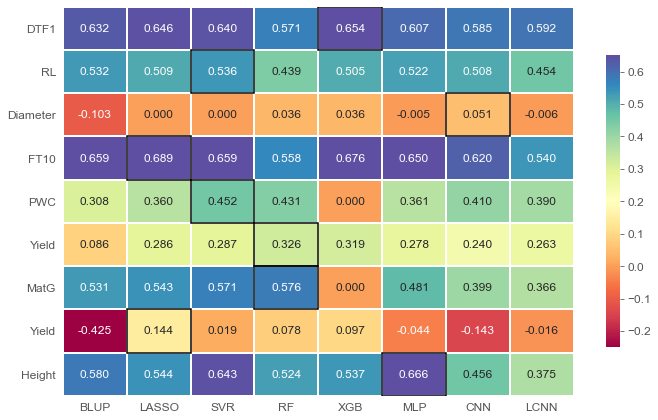

In [161]:
fig, ax = plt.subplots(figsize=(10,6))

plot_data = df_results_overview.filter(regex='mean').astype(float)
# We use ax parameter to tell seaborn which subplot to use for this plot
label_df = pd.DataFrame(columns=['BLUP', 'LASSO', 'SVR', 'RF', 'XGB', 'MLP', 'CNN', 'LCNN'])
row_max = plot_data.idxmax(axis=1)
for index, row in plot_data.iterrows():
    for model in label_df.columns:
        if row_max[index] == model + '_mean':
            label_df.at[index, model] = "{:.3f}".format(row[model + '_mean'])
        else:
            label_df.at[index, model] = "{:.3f}".format(row[model + '_mean'])
sns.heatmap(data=plot_data, cmap="Spectral", cbar_kws={"shrink": .75}, vmin=-0.25, vmax=0.65,
            annot=label_df, fmt='', linewidths=1.5, linecolor='white', cbar=True, annot_kws={"size": 12})    
ax.set_xticklabels([model.split('_')[0] for model in plot_data.columns], rotation=0)
ax.set_yticklabels(df_results_overview['phenotype'], rotation=0)
ax.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=True,
               labelbottom=True)

for row, index in enumerate(plot_data.index):
    position = plot_data.columns.get_loc(row_max[index])
    ax.add_patch(Rectangle((position, row),1,1, fill=False, edgecolor='0', lw=1.5))
    
fig.tight_layout()
plt.savefig('/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/heatmap_real_world_data.svg', bbox_inches='tight', dpi=600)
plt.show()

## simulation

In [168]:
results_dirs = {
    'Simulation': '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10'
}
df_results_overview = results_dict_to_dataframe(get_dict_complete_species(results_dirs))

multiple results for localcnn and phenotype sim11_shift
multiple results for cnn and phenotype sim11_shift


In [169]:
df_results_overview
# simulations
## h=0.85: 18, 16, 15, 17, 19, 39, 20, 21, 22
## h=0.7: 23, 24, 25, 26, 27, 40, 28, 29, 30
## h=0.95: 31, 32, 33, 34, 35, 41, 36, 37, 38
sim_085 = ['sim' + str(index) + '_shift' for index in [18, 16, 15, 17, 19, 39, 20, 21, 22]]
sim_07 = ['sim' + str(index) + '_shift' for index in [23, 24, 25, 26, 27, 40, 28, 29, 30]]
sim_095 = ['sim' + str(index) + '_shift' for index in [31, 32, 33, 34, 35, 41, 36, 37, 38]]

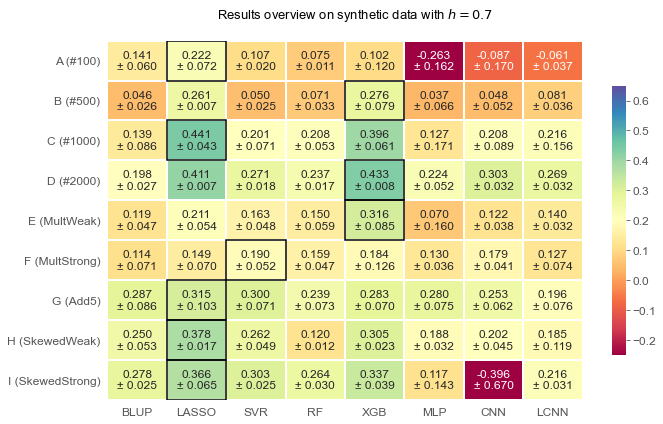

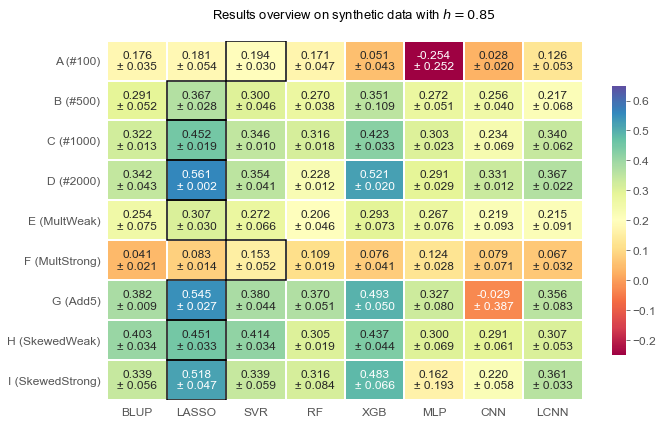

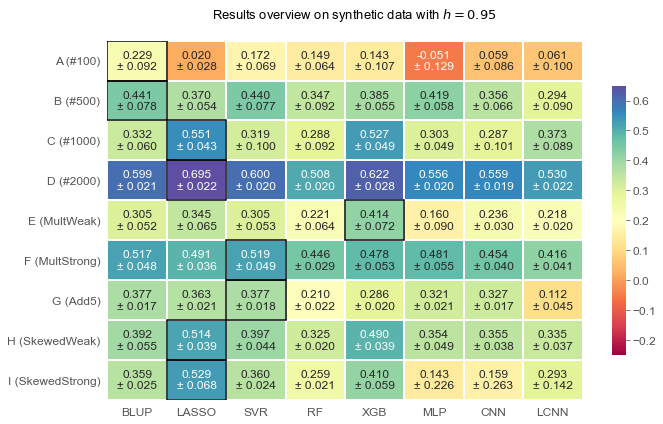

In [170]:
for sim_config, number in zip([sim_07, sim_085, sim_095], ['07', '085', '095']):
    df_config = df_results_overview[df_results_overview['phenotype'].isin(sim_config)]
    df_config = df_config.set_index('phenotype').loc[sim_config]
    df_config.loc[:, 'phenotype'] = ['A' + ' (#100)',
                                     'B' + ' (#500)', 
                                     'C' + ' (#1000)', 
                                     'D' + ' (#2000)',
                                     'E' + ' (MultWeak)', 
                                     'F' + ' (MultStrong)', 
                                     'G' + ' (Add5)', 
                                     'H' + ' (SkewedWeak)', 
                                     'I' + ' (SkewedStrong)']
    df_config.reset_index(inplace=True, drop=True)
    label_df = pd.DataFrame(columns=['BLUP', 'LASSO', 'SVR', 'RF', 'XGB', 'MLP', 'CNN', 'LCNN'])
    for index, row in df_config.iterrows():
        for model in label_df.columns:
            label_df.at[index, model] = \
                "{:.3f}".format(row[model + '_mean']) + "\n\u00B1 {:.3f}".format(row[model + '_std'])
    
    fig, ax = plt.subplots(figsize=(10,6))

    plot_data = df_config.filter(regex='mean').astype(float)
    
    # We use ax parameter to tell seaborn which subplot to use for this plot
    sns.heatmap(data=plot_data, cmap="Spectral", cbar_kws={"shrink": .75}, vmin=-0.25, vmax=0.65,
                annot=label_df, fmt='', linewidths=1.5, linecolor='white', cbar=True, annot_kws={"size": 12, "ha": "center"})
    ax.set_xticklabels([model.split('_')[0] for model in plot_data.columns], rotation=0)
    ax.set_yticklabels(df_config['phenotype'], rotation=0)
    ax.tick_params(top=False,
                   bottom=False,
                   left=False,
                   right=False,
                   labelleft=True,
                   labelbottom=True)
    row_max = plot_data.idxmax(axis=1)
    for row, index in enumerate(plot_data.index):
        position = plot_data.columns.get_loc(row_max[index])
        ax.add_patch(Rectangle((position, row),1,1, fill=False, edgecolor='0', lw=1.5))
    h = '0.' + str(number.split('0')[1])
    fig.suptitle('Results overview on synthetic data with '+ r'$\mathit{h=' + h + '}$', fontsize=13)
    fig.tight_layout()
    plt.savefig('/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/heatmap_sim_' + number + '.svg', bbox_inches='tight', dpi=600)
    plt.savefig('/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/heatmap_sim_' + number + '.pdf', bbox_inches='tight', dpi=600)
    plt.savefig('/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/heatmap_sim_' + number + '.jpg', bbox_inches='tight', dpi=600)
    plt.show()

# Feat Importance Analyse

In [109]:
sim_config_folder = '/bit_storage/Workspace/Maura/PhenotypePred/data/Simulations/'


In [110]:
all_sim_configs = pd.DataFrame(columns=['sim_id', 'type', 'snp_id', 'beta'])
for sim_id in range(15, 42):
    if 15 <= sim_id <= 22:
        post_fix = '15-22'
    elif 23 <= sim_id <= 30:
        post_fix = '23-30'
    elif 31 <= sim_id <= 38:
        post_fix = '31-38'
    else:
        post_fix = '39-41'
    background_file = pd.read_csv(glob.glob(sim_config_folder + 'background_10k_maf10_' + post_fix + '.csv')[0])
    betas_background_file = pd.read_csv(glob.glob(sim_config_folder + 'betas_background_10k_maf10_' + post_fix + '.csv')[0])
    sim_config_file = pd.read_csv(glob.glob(sim_config_folder + 'simulation_config_10k_maf10_' + post_fix + '.csv')[0])
    df_to_append = pd.DataFrame(columns=['sim_id', 'type', 'snp_id', 'beta'])
    column = 'sim' + str(sim_id)
    df_to_append['snp_id'] = background_file[column]
    df_to_append['type'] = 'background'
    df_to_append['sim_id'] = column
    df_to_append['beta'] = betas_background_file[column]
    sim_conf = sim_config_file[sim_config_file['simulation'] == sim_id]
    for index, causal_marker in enumerate(sim_conf['causal_marker'][sim_conf.index[0]][2:-2].split('\' \'')):
        row_id = df_to_append.shape[0]
        df_to_append.at[row_id, 'sim_id'] = column
        df_to_append.at[row_id, 'snp_id'] = causal_marker
        df_to_append.at[row_id, 'type'] = 'causal'
        df_to_append.at[row_id, 'beta'] = float(sim_conf['causal_beta'][sim_conf.index[0]][1:-1].split(',')[index])
    all_sim_configs = all_sim_configs.append(df_to_append, ignore_index=True) 
    

In [111]:
float(sim_conf['causal_beta'][sim_conf.index[0]][1:-1].split(',')[index])


0.2725308764902463

In [112]:
all_sim_configs

,sim_id,type,snp_id,beta
0,sim15,background,11388092_3,-0.028842
1,sim15,background,8275647_3,0.064575
2,sim15,background,5691287_5,-0.114782
3,sim15,background,16355833_3,0.00752
4,sim15,background,18221353_5,0.065791
...,...,...,...,...
27040,sim41,background,13051940_3,0.109865
27041,sim41,background,10403149_2,0.126685
27042,sim41,background,5758047_4,-0.165517
27043,sim41,causal,11488251_5,0.259605


In [113]:
results_directory_genotype_level = '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10'

all_feat_imps = pd.DataFrame(columns=['sim_id', 'model', 'snp_id', 'feat_imp'])

genotype_name = results_directory_genotype_level.split('/')[-1] + '.h5'

for study in os.listdir(results_directory_genotype_level):
    if not os.path.isdir(results_directory_genotype_level + '/' + study):
        continue
    for phenotype in os.listdir(results_directory_genotype_level + '/' + study):
        print('++++++++++++++ PHENOTYPE ' + phenotype + ' ++++++++++++++')
        current_directory = results_directory_genotype_level + '/' + study + '/' + phenotype + '/'
        if not os.path.isdir(current_directory):
            continue
        for path in glob.glob(current_directory + '*'):
            if not os.path.isdir(path):
                continue
            if len(glob.glob(path + '/Results_over*.csv')) == 0:
                continue
            models = path.split('/')[-1].split('_')[3].split('+')
            print('working on ' + path)
            for current_model in models:
                if current_model in ['randomforest', 'xgboost', 'linearregression']:
                    feat_imps_to_append = None
                    print('Model: ' + current_model)
                    for outerfold_path in glob.glob(path + '/outerfold*'):
                        print(glob.glob(path + '/outerfold*'))
                        current_directory = outerfold_path + '/' + current_model + '/'
                        try:
                            feat_imp = pd.read_csv(current_directory + 'final_model_feature_importances.csv')
                            feat_imp.rename(columns={'snp_ids_0': 'snp_id'}, inplace=True)
                            feat_imp.rename(columns={'snp_ids_standard': 'snp_id'}, inplace=True)
                            if feat_imps_to_append is None:
                                feat_imps_to_append = feat_imp.copy()
                            else:
                                feat_imps_to_append = feat_imps_to_append.join(feat_imp.set_index('snp_id'), on=['snp_id'], rsuffix=outerfold_path.split('/')[-1], how='outer')
                        except Exception as exc:
                            print(exc)
                    if feat_imps_to_append is not None:
                        cols_to_drop = feat_imps_to_append.columns[1:]
                        feat_imps_to_append['feat_imp'] = feat_imps_to_append.iloc[:, 1:].fillna(0).mean(axis=1)
                        feat_imps_to_append['sim_id'] = phenotype.split('_')[0]
                        feat_imps_to_append['model'] = current_model
                        feat_imps_to_append.drop(cols_to_drop, axis=1, inplace=True)
                        all_feat_imps = all_feat_imps.append(feat_imps_to_append, ignore_index=True) 

++++++++++++++ PHENOTYPE sim1_shift ++++++++++++++
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1-4/sim1_shift/nested-cv_3-5_MAF0_mlp_2022-04-14_12-04-20
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1-4/sim1_shift/nested-cv_3-5_MAF0_localcnn_2022-04-14_15-59-22
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1-4/sim1_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-14_11-56-04
Model: randomforest
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1-4/sim1_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-14_11-56-04/outerfold_0', '/bit_storage/Workspace/Maura/Pheno

Model: xgboost
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1-4/sim3_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-14_11-57-05/outerfold_0', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1-4/sim3_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-14_11-57-05/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1-4/sim3_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-14_11-57-05/outerfold_2']
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1-4/sim3_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-14_11-57-05/outerfold_0', '/bit_s

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim7_shift/nested-cv_3-5_MAF0_localcnn_2022-04-17_07-11-09
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim7_shift/nested-cv_3-5_MAF0_cnn_2022-04-18_18-09-45
++++++++++++++ PHENOTYPE sim11_shift ++++++++++++++
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim11_shift/nested-cv_3-5_MAF0_xgboost+randomforest+linearregression_2022-04-16_13-57-59
Model: xgboost
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim11_shift/nested-cv_3-5_MAF0_xgboost+randomforest+linearregression_2022-04-16_13-57-59/outerfold_2', '/bit_storage/Workspa

['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim10_shift/nested-cv_3-5_MAF0_xgboost+randomforest+linearregression_2022-04-16_12-12-20/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim10_shift/nested-cv_3-5_MAF0_xgboost+randomforest+linearregression_2022-04-16_12-12-20/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim10_shift/nested-cv_3-5_MAF0_xgboost+randomforest+linearregression_2022-04-16_12-12-20/outerfold_0']
Model: randomforest
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim10_shift/nested-cv_3-5_MAF0_xgboost+randomforest+linearregression_2022-04-16_12-12-20/oute

Model: linearregression
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim6_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-15_17-21-08/outerfold_0', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim6_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-15_17-21-08/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim6_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-15_17-21-08/outerfold_1']
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_1000_5-11/sim6_shift/nested-cv_3-5_MAF0_randomforest+svm+linearregression+xgboost_2022-04-

['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_14-15/sim15_shift/nested-cv_3-5_MAF0_randomforest+xgboost_2022-04-21_09-38-30/outerfold_0', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_14-15/sim15_shift/nested-cv_3-5_MAF0_randomforest+xgboost_2022-04-21_09-38-30/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_14-15/sim15_shift/nested-cv_3-5_MAF0_randomforest+xgboost_2022-04-21_09-38-30/outerfold_2']
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_14-15/sim15_shift/nested-cv_3-5_MAF0_localcnn_2022-04-22_12-49-16
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsi

['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_16-17/sim17_shift/nested-cv_3-5_MAF0_randomforest+xgboost_2022-04-21_11-42-11/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_16-17/sim17_shift/nested-cv_3-5_MAF0_randomforest+xgboost_2022-04-21_11-42-11/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_16-17/sim17_shift/nested-cv_3-5_MAF0_randomforest+xgboost_2022-04-21_11-42-11/outerfold_0']
Model: xgboost
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_16-17/sim17_shift/nested-cv_3-5_MAF0_randomforest+xgboost_2022-04-21_11-42-11/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulatio

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_18-22/sim18_shift/nested-cv_3-5_MAF0_svm_2022-04-22_15-30-15
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_18-22/sim18_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-34-22
Model: linearregression
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_18-22/sim18_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-34-22/outerfold_0', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_18-22/sim18_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-34-22/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_m

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_18-22/sim19_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-59-42
Model: linearregression
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_18-22/sim19_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-59-42/outerfold_0', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_18-22/sim19_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-59-42/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_18-22/sim19_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-59-42/outerfold_1']
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim23_shift/nested-cv_3-5_MAF0_localcnn_2022-04-22_19-49-02
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim23_shift/nested-cv_3-5_MAF0_randomforest_2022-04-22_16-34-50
Model: randomforest
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim23_shift/nested-cv_3-5_MAF0_randomforest_2022-04-22_16-34-50/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim23_shift/nested-cv_3-5_MAF0_randomforest_2022-04-22_16-34-50/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simula

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim25_shift/nested-cv_3-5_MAF0_randomforest_2022-04-22_21-42-56
Model: randomforest
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim25_shift/nested-cv_3-5_MAF0_randomforest_2022-04-22_21-42-56/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim25_shift/nested-cv_3-5_MAF0_randomforest_2022-04-22_21-42-56/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim25_shift/nested-cv_3-5_MAF0_randomforest_2022-04-22_21-42-56/outerfold_0']
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim30_shift/nested-cv_3-5_MAF0_cnn_2022-04-23_04-50-16
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim30_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_19-59-25
Model: linearregression
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim30_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_19-59-25/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim30_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_19-59-25/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_m

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim27_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-44-44
Model: linearregression
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim27_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-44-44/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim27_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-44-44/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_23-30/sim27_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_16-44-44/outerfold_0']
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim34_shift/nested-cv_3-5_MAF0_svm_2022-04-22_22-03-16
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim34_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_20-54-07
Model: linearregression
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim34_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_20-54-07/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim34_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_20-54-07/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_m

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim32_shift/nested-cv_3-5_MAF0_xgboost_2022-04-23_02-41-07
Model: xgboost
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim32_shift/nested-cv_3-5_MAF0_xgboost_2022-04-23_02-41-07/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim32_shift/nested-cv_3-5_MAF0_xgboost_2022-04-23_02-41-07/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim32_shift/nested-cv_3-5_MAF0_xgboost_2022-04-23_02-41-07/outerfold_0']
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_3

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim31_shift/nested-cv_3-5_MAF0_svm_2022-04-22_18-25-21
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim31_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_18-23-45
Model: linearregression
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim31_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_18-23-45/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim31_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_18-23-45/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_m

['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim37_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_23-32-47/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim37_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_23-32-47/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim37_shift/nested-cv_3-5_MAF0_linearregression_2022-04-22_23-32-47/outerfold_0']
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim37_shift/nested-cv_3-5_MAF0_randomforest_2022-04-23_01-26-16
Model: randomforest
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabido

working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim38_shift/nested-cv_3-5_MAF0_localcnn_2022-04-25_06-58-39
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim38_shift/nested-cv_3-5_MAF0_blup_2022-04-26_06-40-55
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_31-38/sim38_shift/nested-cv_3-5_MAF0_cnn_2022-04-24_18-54-27
++++++++++++++ PHENOTYPE sim39_shift ++++++++++++++
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_39-41/sim39_shift/nested-cv_3-5_MAF0_mlp_2022-04-24_12-19-13
working on /bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10

['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_39-41/sim40_shift/nested-cv_3-5_MAF0_randomforest_2022-04-24_11-04-01/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_39-41/sim40_shift/nested-cv_3-5_MAF0_randomforest_2022-04-24_11-04-01/outerfold_1', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_39-41/sim40_shift/nested-cv_3-5_MAF0_randomforest_2022-04-24_11-04-01/outerfold_0']
['/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10k_maf10_39-41/sim40_shift/nested-cv_3-5_MAF0_randomforest_2022-04-24_11-04-01/outerfold_2', '/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/Simulation/ld_pruned_arabidopsis_10k_maf10/Simulation_10

In [114]:
stats = pd.DataFrame(
    columns=['sim_id', 'model', '#features_with_imp', '#detected_background_snps', '#background_snps', 'ratio_background_detected', 'ratio_background_detected_by_feat_imp',
             '#detected_causal_snps', '#causal_snps', 'ratio_causal_detected', 'causal_snps_detected', 'featimp_rank_causal_snps'])
for sim_id in set(all_sim_configs.sim_id):
    config_simid = all_sim_configs[all_sim_configs.sim_id == sim_id]
    feat_imp_simid = all_feat_imps[all_feat_imps.sim_id == sim_id]
    for model in set(feat_imp_simid.model):
        new_row = {}
        new_row['sim_id'] = sim_id
        new_row['model'] = model
        feat_imp_model = feat_imp_simid[feat_imp_simid.model == model]
        non_zero_featimps = feat_imp_model[feat_imp_model.feat_imp != 0.0]
        new_row['#features_with_imp'] = non_zero_featimps.shape[0]
        background = config_simid[config_simid.type == 'background']
        causal = config_simid[config_simid.type=='causal']
        new_row['#detected_background_snps'] = len(set(non_zero_featimps.snp_id).intersection(set(background.snp_id)))
        new_row['#background_snps'] = len(set(background.snp_id))
        new_row['ratio_background_detected_by_feat_imp'] = round(new_row['#detected_background_snps'] / new_row['#features_with_imp'], 2) if new_row['#features_with_imp'] != 0 else np.nan
        new_row['ratio_background_detected'] = round(new_row['#detected_background_snps'] / new_row['#background_snps'], 2)
        new_row['#detected_causal_snps'] = len(set(non_zero_featimps.snp_id).intersection(set(causal.snp_id)))
        new_row['#causal_snps'] = len(set(causal.snp_id))
        new_row['ratio_causal_detected'] = round(new_row['#detected_causal_snps'] / new_row['#causal_snps'], 2)
        new_row['causal_snps_detected'] = 'Yes' if new_row['ratio_causal_detected'] == 1 else 'No'
        featimp_sorted = non_zero_featimps.sort_values(by='feat_imp', ascending=False).reset_index(drop=True)
        new_row['featimp_rank_causal_snps'] = list(featimp_sorted[featimp_sorted.snp_id.isin(set(causal.snp_id))].index + 1)
        stats = stats.append(new_row, ignore_index=True)
stats = stats.sort_values(by=['sim_id', 'model'])

In [115]:
stats.to_csv('Simulated_data_statistics_beta_vs_featimp.csv')
stats

,sim_id,model,#features_with_imp,#detected_background_snps,#background_snps,ratio_background_detected,ratio_background_detected_by_feat_imp,#detected_causal_snps,#causal_snps,ratio_causal_detected,causal_snps_detected,featimp_rank_causal_snps
28,sim15,linearregression,324,71,1000,0.07,0.22,1,1,1.0,Yes,[1]
29,sim15,randomforest,2479,279,1000,0.28,0.11,1,1,1.0,Yes,[1]
27,sim15,xgboost,360,75,1000,0.07,0.21,1,1,1.0,Yes,[1]
70,sim16,linearregression,222,39,1000,0.04,0.18,1,1,1.0,Yes,[1]
71,sim16,randomforest,2344,254,1000,0.25,0.11,1,1,1.0,Yes,[1]
...,...,...,...,...,...,...,...,...,...,...,...,...
74,sim40,randomforest,2234,249,1000,0.25,0.11,2,2,1.0,Yes,"[2, 17]"
72,sim40,xgboost,1944,198,1000,0.2,0.1,2,2,1.0,Yes,"[39, 168]"
61,sim41,linearregression,300,57,1000,0.06,0.19,2,2,1.0,Yes,"[1, 30]"
62,sim41,randomforest,2139,250,1000,0.25,0.12,2,2,1.0,Yes,"[22, 157]"


In [116]:
stats.to_csv('Simulated_data_statistics_beta_vs_featimp.csv')

In [117]:
sim_085 = ['sim' + str(index) for index in [18, 16, 15, 17, 19, 39, 20, 21, 22]]
sim_07 = ['sim' + str(index) for index in [23, 24, 25, 26, 27, 40, 28, 29, 30]]
sim_095 = ['sim' + str(index) for index in [31, 32, 33, 34, 35, 41, 36, 37, 38]]

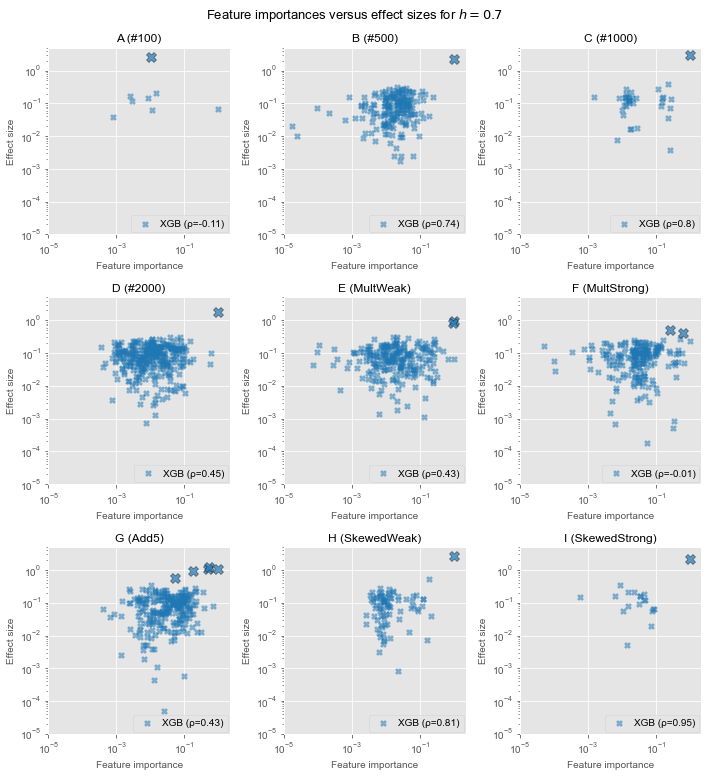

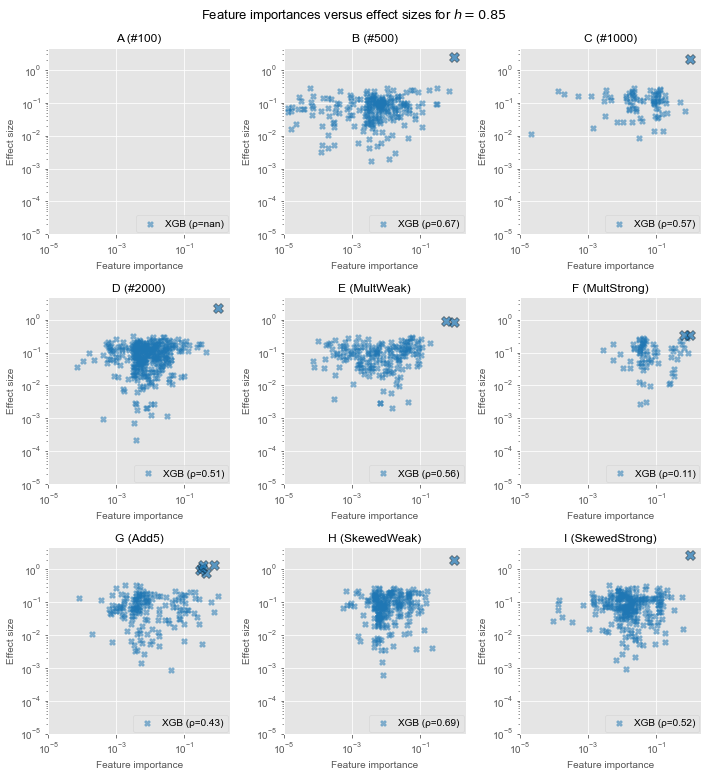

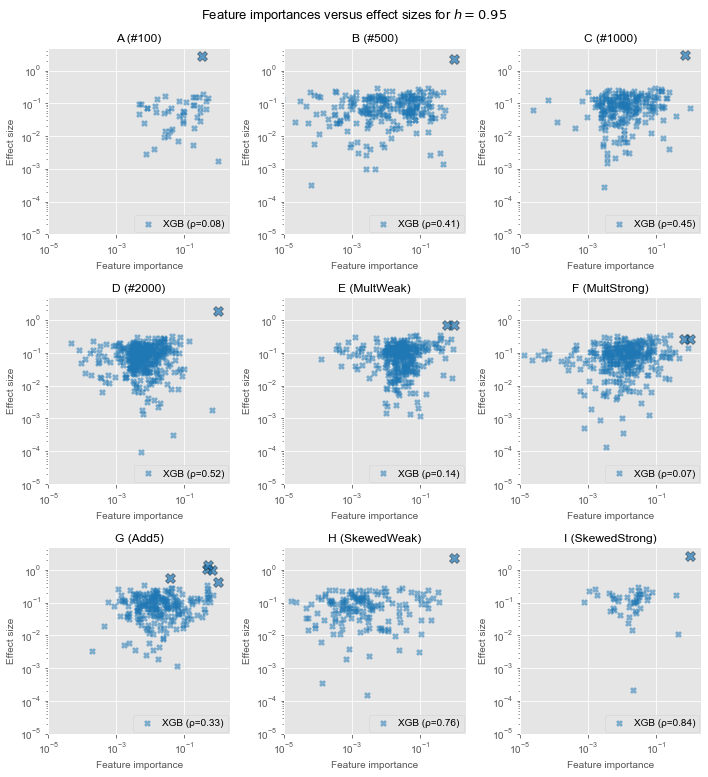

In [155]:
cm=1
titles = [
    'A' + ' (#100)',
    'B' + ' (#500)', 
    'C' + ' (#1000)', 
    'D' + ' (#2000)',
    'E' + ' (MultWeak)', 
    'F' + ' (MultStrong)', 
    'G' + ' (Add5)', 
    'H' + ' (SkewedWeak)', 
    'I' + ' (SkewedStrong)'
]

for sim_config, number in zip([sim_07, sim_085, sim_095], ['07', '085', '095']):
    fig = plt.figure(figsize=(10*cm, 11*cm))
    sim_info = all_sim_configs[all_sim_configs['sim_id'].isin(sim_config)]
    feat_info = all_feat_imps[all_feat_imps['sim_id'].isin(sim_config)]
    
    beta_max = sim_info[sim_info['beta']!= 0]['beta'].astype(float).abs().max()
    feat_imp_max = feat_info[feat_info['feat_imp']!=0]['feat_imp'].astype(float).abs().max()
    beta_min = sim_info[sim_info['beta']!= 0]['beta'].astype(float).abs().min()
    feat_imp_min = feat_info[feat_info['feat_imp']!=0]['feat_imp'].astype(float).abs().min()
    for plot_nr, sim_id in enumerate(sim_config):
        ax = fig.add_subplot(3, 3, plot_nr+1)
        sim_info_for_id = sim_info[sim_info['sim_id'] == sim_id]
        feat_info_for_id = feat_info[feat_info['sim_id'] == sim_id]
        for model in ['xgboost']: #, 'xgboost', 'linearregression']:
            feat_info_for_model = feat_info_for_id[feat_info_for_id['model'] == model]
            plot_info = sim_info_for_id.iloc[:, 1:].join(feat_info_for_model.iloc[:, 2:].set_index('snp_id'), on=['snp_id']).fillna(0)
            plot_info_non_zero = plot_info[plot_info['feat_imp'] != 0]
            corr = np.corrcoef(plot_info_non_zero['beta'].astype(float), plot_info_non_zero['feat_imp'].astype(float))[0][1]
            plot_info_non_zero['beta'] = plot_info_non_zero['beta'].astype(float).abs()
            plot_info_non_zero['feat_imp'] = plot_info_non_zero['feat_imp'].astype(float).abs()
            plot_info_non_zero['feat_imp'] = (plot_info_non_zero['feat_imp']-plot_info_non_zero['feat_imp'].min()) / (plot_info_non_zero['feat_imp'].max()-plot_info_non_zero['feat_imp'].min())
            plot_info_background = plot_info_non_zero[plot_info_non_zero['type'] == 'background']
            plot_info_causal = plot_info_non_zero[plot_info_non_zero['type'] == 'causal']
            if model == 'xgboost':
                marker = 'X'
                alpha_offset = 0.2  # 0 if all are plotted
                c = 'tab:blue'
                label = 'XGB'
            elif model == 'randomforest':
                marker = 's'
                alpha_offset=0.2    #0 if all are plotted #0.2 for single
                c = 'tab:orange'
                label = 'RF'
            elif model =='linearregression':
                marker = 'o'
                alpha_offset=0.2
                c = 'tab:green'
                label='LASSO'
            # sns.scatterplot(data=plot_info_background, x='feat_imp', y='beta',ax=ax, marker=marker, alpha=alpha, hue='type')
            ax.scatter(x=plot_info_background['feat_imp'], y=plot_info_background['beta'], marker=marker, c=c, alpha=0.3+alpha_offset, label=label + ' (\u03C1=' + str(round(corr, 2)) +')')
            ax.scatter(x=plot_info_causal['feat_imp'], y=plot_info_causal['beta'], marker=marker, c=c, s=100, alpha=0.7,    #0.5 if all are plotted #0.7 for single
                       label='_nolegend_', edgecolors='black')
            # sns.scatterplot(data=plot_info_causal, x='feat_imp', y='beta', ax=ax, marker=marker, alpha=alpha, palette=palette)
        # ax.set(yscale="log"
        ax.set(xscale="log", yscale="log")
        #ax.set_xlim(feat_imp_min, feat_imp_max) #+np.exp(0.1)) #+np.exp(0.7))
        ax.set_xlim(0.00001, 1 + np.exp(0.2))
        ax.set_ylim(0.00001, beta_max+2) #+np.exp(0.1)) #+np.exp(0.7))
        ax.set_xlabel('Feature importance', fontsize=10)
        ax.set_ylabel('Effect size', fontsize=10)
        ax.set_title(titles[plot_nr], fontsize=12)
        ax.legend(loc='lower right', fontsize=10, labelspacing=0.2, handletextpad=0.5, borderaxespad=0.2)
        ax.tick_params(labelsize=10)
    # plt.suptitle(number)
    plt.subplots_adjust(hspace=0.1)
    h = '0.' + str(number.split('0')[1])
    fig.suptitle('Feature importances versus effect sizes for '+ r'$\mathit{h=' + h + '}$', fontsize=13)
    fig.tight_layout()
    plt.savefig('/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/scatterplot_xgb_' + number + '.svg', bbox_inches='tight', dpi=300)
    plt.savefig('/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/scatterplot_xgb_' + number + '.jpg', bbox_inches='tight', dpi=300)
    plt.savefig('/bit_storage/Workspace/Maura/PhenotypePred/FrontiersPaperExperiments/scatterplot_xgb_' + number + '.pdf', bbox_inches='tight', dpi=300)
    plt.show()